In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
from sklearn.preprocessing import LabelEncoder

from scipy import stats
from matplotlib import pyplot as plt

%matplotlib inline

from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols

import statsmodels.api as sm

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [17]:
data = pd.read_csv("../DATA/crime_records.csv")

In [18]:
data.head(3)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.000000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.964805,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.779775,5.459174e+06


In [19]:
data.shape

(624038, 10)

In [20]:
data.dtypes

TYPE              object
YEAR               int64
MONTH              int64
DAY                int64
HOUR               int64
MINUTE             int64
HUNDRED_BLOCK     object
NEIGHBOURHOOD     object
X                float64
Y                float64
dtype: object

In [21]:
data.isnull().sum()

TYPE                 0
YEAR                 0
MONTH                0
DAY                  0
HOUR                 0
MINUTE               0
HUNDRED_BLOCK       13
NEIGHBOURHOOD    64962
X                  120
Y                  120
dtype: int64

In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,624038.0,2.010538e+03,5.166660e+00,2003.0,2.006000e+03,2.010000e+03,2.015000e+03,2019.0
MONTH,624038.0,6.524269e+00,3.388705e+00,1.0,4.000000e+00,7.000000e+00,9.000000e+00,12.0
DAY,624038.0,1.538950e+01,8.744227e+00,1.0,8.000000e+00,1.500000e+01,2.300000e+01,31.0
HOUR,624038.0,1.234601e+01,7.612785e+00,0.0,6.000000e+00,1.400000e+01,1.900000e+01,23.0
MINUTE,624038.0,1.540147e+01,1.825289e+01,0.0,0.000000e+00,3.000000e+00,3.000000e+01,59.0
X,623918.0,4.430545e+05,1.476274e+05,0.0,4.900237e+05,4.915280e+05,4.934876e+05,511303.0
Y,623918.0,4.911580e+06,1.636310e+06,0.0,5.453771e+06,5.456911e+06,5.458686e+06,5512579.0


In [23]:
data.apply(pd.Series.nunique)

TYPE                 11
YEAR                 17
MONTH                12
DAY                  31
HOUR                 24
MINUTE               60
HUNDRED_BLOCK     22180
NEIGHBOURHOOD        24
X                123138
Y                122552
dtype: int64

In [24]:
data['TYPE'].value_counts()

Theft from Vehicle                                        209609
Mischief                                                   83970
Break and Enter Residential/Other                          66378
Other Theft                                                64611
Offence Against a Person                                   62078
Theft of Vehicle                                           41528
Break and Enter Commercial                                 38916
Theft of Bicycle                                           31112
Vehicle Collision or Pedestrian Struck (with Injury)       25294
Vehicle Collision or Pedestrian Struck (with Fatality)       290
Homicide                                                     252
Name: TYPE, dtype: int64

Text(0, 0.5, 'crime count')

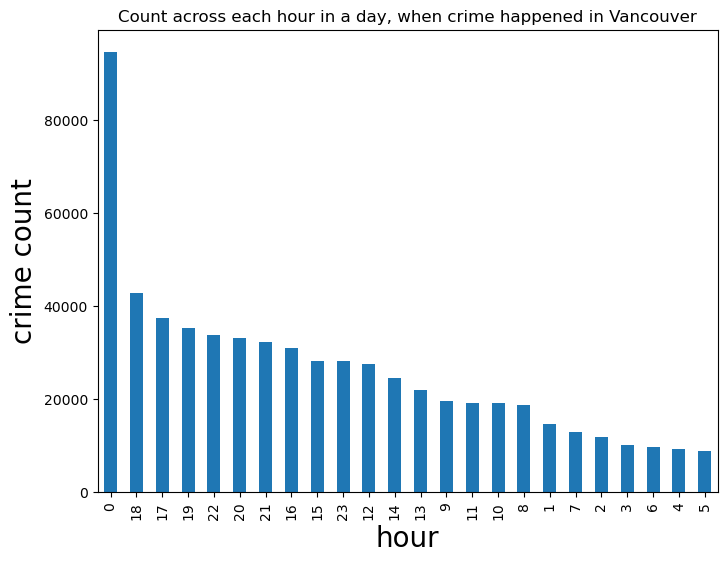

In [26]:
nameplot = data['HOUR'].value_counts().plot.bar(title='Count across each hour in a day, when crime happened in Vancouver', figsize=(8,6))
nameplot.set_xlabel('hour',size=20)
nameplot.set_ylabel('crime count',size=20)

In [43]:
hour = data['HOUR']
hour.describe()

count    624038.000000
mean         12.346011
std           7.612785
min           0.000000
25%           6.000000
50%          14.000000
75%          19.000000
max          23.000000
Name: HOUR, dtype: float64

In [28]:
data.corr()

,YEAR,MONTH,DAY,HOUR,MINUTE,X,Y
YEAR,1.000000,-0.001740,-0.008111,-0.006974,0.052492,-0.002711,-0.002655
MONTH,-0.001740,1.000000,0.006583,0.002129,-0.003783,0.003530,0.003407
DAY,-0.008111,0.006583,1.000000,0.001878,0.003289,-0.003983,-0.004025
HOUR,-0.006974,0.002129,0.001878,1.000000,0.113185,0.540182,0.540229
MINUTE,0.052492,-0.003783,0.003289,0.113185,1.000000,0.281291,0.281143
X,-0.002711,0.003530,-0.003983,0.540182,0.281291,1.000000,0.999843
Y,-0.002655,0.003407,-0.004025,0.540229,0.281143,0.999843,1.000000


<AxesSubplot:xlabel='HOUR', ylabel='count'>

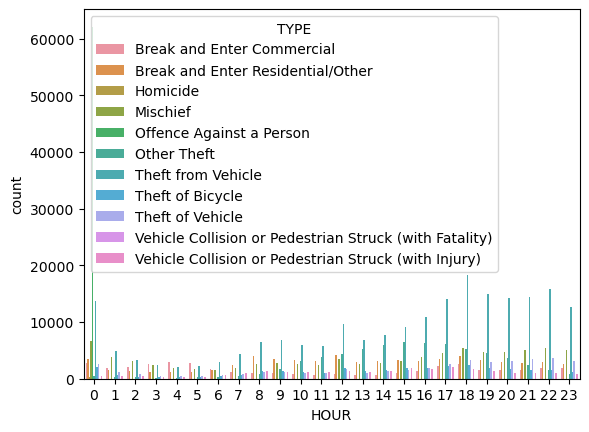

In [29]:
sns.countplot(x=hour, hue='TYPE',data=data)

In [65]:
data['HOUR'].value_counts()

0     94539
18    42756
17    37369
19    35296
22    33666
20    33017
21    32320
16    31006
15    28205
23    28131
12    27562
14    24489
13    21856
9     19594
11    19143
10    19076
8     18774
1     14706
7     12779
2     11862
3     10122
6      9581
4      9290
5      8899
Name: HOUR, dtype: int64

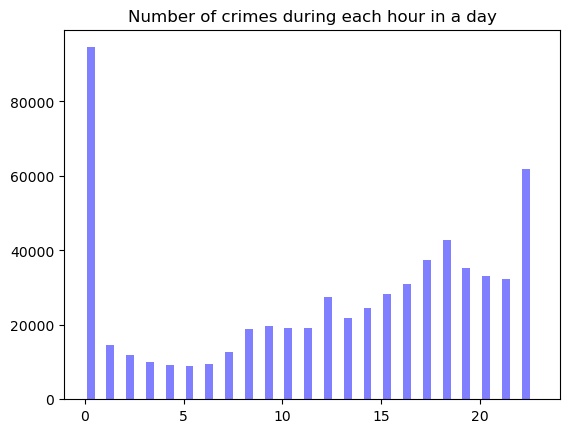

In [62]:
num_bins = 23
n, bins, patches = plt.hist((hour, ['TYPE' == 'Theft of Vehicle']), num_bins, facecolor='blue', alpha=0.5, )
plt.title('Number of crimes during each hour in a day')
plt.show()

In [64]:
data.sample(5)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,day_night
552132,Theft of Bicycle,2004,3,22,0,0,ADANAC ST / VICTORIA DR,Grandview-Woodland,495228.194290,5.458309e+06,night
289855,Other Theft,2015,6,14,11,5,56XX VICTORIA DR,Kensington-Cedar Cottage,495228.058279,5.453413e+06,day
200253,Offence Against a Person,2018,9,29,0,0,OFFSET TO PROTECT PRIVACY,NaN,0.000000,0.000000e+00,night
236774,Offence Against a Person,2010,3,13,0,0,OFFSET TO PROTECT PRIVACY,NaN,0.000000,0.000000e+00,night
246732,Offence Against a Person,2003,6,19,0,0,OFFSET TO PROTECT PRIVACY,NaN,0.000000,0.000000e+00,night


In [38]:
print(type(day_night))

<class 'pandas.core.series.Series'>


In [37]:
day_night.sample(5)

371630    night
118733    night
503016    night
410973    night
263155    night
Name: HOUR, dtype: category
Categories (2, object): ['day' < 'night']

In [45]:
day_night = pd.cut(data['HOUR'], bins = 2, labels = ["day", "night"])
day_night.sample(5)     

153695    night
234038      day
325325    night
269739    night
574382    night
Name: HOUR, dtype: category
Categories (2, object): ['day' < 'night']

In [77]:
def day_night(value):
    if value < 7:
        return "0"
    if 7 <= value < 19:
        return "1"
    elif value >= 19:
        return "0"
 
data['day_night'] = data['HOUR'].map(day_night)
display(data.head())

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,day_night
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.000000,5.453433e+06,1
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.964805,5.457110e+06,0
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.779775,5.459174e+06,0
3,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.943352,5.459166e+06,0
4,Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.385727,5.459161e+06,0


In [66]:
data.head(3)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,day_night
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.000000,5.453433e+06,day
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.964805,5.457110e+06,night
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.779775,5.459174e+06,night


<AxesSubplot:xlabel='HOUR', ylabel='count'>

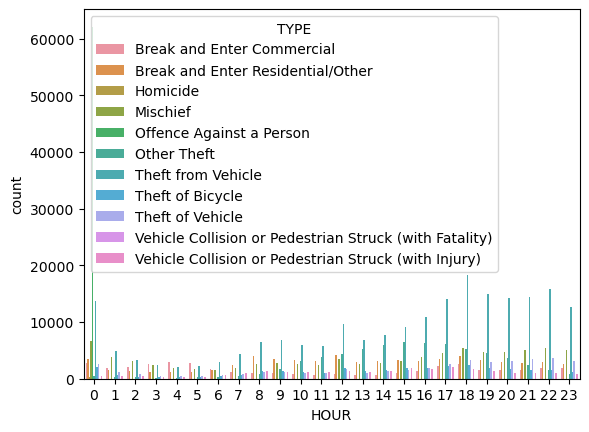

In [27]:
sns.countplot(x = hour, hue = 'TYPE', data = data)

In [11]:
def generateBaseMap(default_location=[49.246292, -123.116226], default_zoom_start=12):
    '''
    Create a base map
    '''
    base_map = folium.Map(
        location = default_location
        , control_scale = True
        , zoom_start = default_zoom_start
    )
    
    return base_map

In [12]:
base_map = generateBaseMap(default_location=[49.246292, -123.116226])
display(base_map)

In [13]:
vancouver_location = [49.246292, -123.116226]
m = generateBaseMap(default_location=vancouver_location)
for i in range(0, len(data.head(100))):
    folium.Marker(location=[data.iloc[i]['Y'], data.iloc[i]['X']], popup=data.iloc[i]['TYPE']).add_to(m)
m

In [15]:
baseMap = folium.Map(location=[49.246292, -123.116226])
for i in range (0, len(data.head(1000))):
    folium.Circle(
        location=[data.iloc[i]['X'], data.iloc[i]['Y']]
        , radius=100
    ).add_to(baseMap)
display(baseMap)

In [6]:
data.head(3)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.000000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.964805,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.779775,5.459174e+06


<AxesSubplot:ylabel='Frequency'>

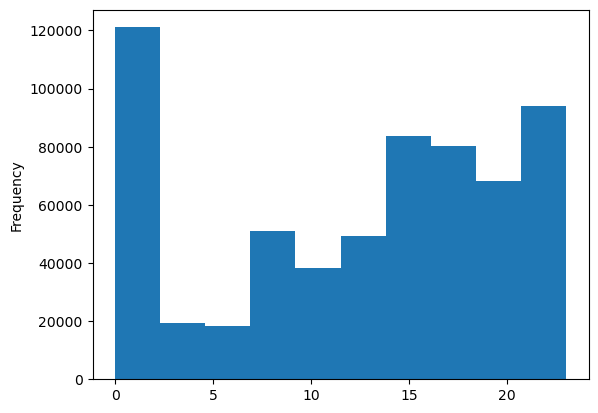

In [74]:
hour.plot.hist()

In [85]:
alpha = 0.05

In [89]:
N = 1000
crime_night = data[data[hour] > 12].sample(N)
crime_am = data[data[hour] <= 12].sample(N)

KeyError: "None of [Int64Index([ 8,  2,  4,  5,  3,  4,  0, 20,  5, 14,\n            ...\n            10,  7,  6, 21,  9, 13,  9, 16, 20, 18],\n           dtype='int64', length=624038)] are in the [columns]"

In [87]:
crime_night_var = crime_night.var()
print(crime_night_var)
crime_day_var = crime_day.var()
print(crime_day_var)

NameError: name 'crime_night' is not defined

In [90]:
std = np.sqrt((crime_night_var + crime_day_var) / 2)
print('std dev:', std)

NameError: name 'crime_night_var' is not defined

In [91]:
t = (crime_night_var.mean() - crime_day_var.mean()) / (std * np.sqrt(2 / N))  # t-statistic
print('t:', t)

NameError: name 'crime_night_var' is not defined

In [92]:
df = 2 * N - 2
df

1998

In [93]:
p = 1 - stats.t.cdf(abs(t), df=df)  # #p-value after comparison with the t 
print("t = " + str(t))
print("p = " + str(2 * p))

NameError: name 't' is not defined

In [ ]:
null_hypothesis = {
  H0: There are is no difference in the number of thefts which occur during the day and night​
    H1: There is a difference in the number of thefts which occur during the day and night 
}

In [94]:
def print_sig(p_value, alpha):
    '''
    Inputs:
    p_value: Calculated p_value
    alpha: Confidence level
    '''
    if p_value < alpha:
        print("We reject our null hypothesis.")
        print(null_hypothesis['H1'])
    elif p_value > alpha:
        print("We fail to reject our null hypothesis.")
        print(null_hypothesis['H0'])
    else:
        print("Our test is inconclusive.")

In [95]:
print("t = " + str(t))
print("p = " + str(p*2))
print_sig(p*2, alpha)

NameError: name 't' is not defined

In [96]:
t2, p2 = stats.ttest_ind(medv_over_6, medv_under_6)
print("t = " + str(t2))
print("p = " + str(p2))
print_sig(p2, alpha)

NameError: name 'medv_over_6' is not defined

In [97]:
data['day_night'].value_counts()

0    321429
1    302609
Name: day_night, dtype: int64

In [100]:
plt.bar(day_night, values, color ='maroon',
        width = 0.4)

NameError: name 'values' is not defined